In [ ]:
# RF with scaling works better in this case compared XGB without scaling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math

In [2]:
# read the respective files from these locations
data_file_training='/data-restricted/PEM/L0162_20200909T0001_20201201T1230.csv'
df = pd.read_csv(data_file_training)
print(df.shape)
print(list(df.columns))

(66331, 46)
['Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM', 'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL', 'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI', 'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'NOX15', 'CO15']


In [3]:
#df.plot(subplots=True,figsize=(60,40))

In [ ]:
df['DateTime']=pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M')
print(df['DateTime'].min(),df['DateTime'].max()) 
#df[['DateTime','Timestamp']].tail()

In [11]:
print(df['EMISSIONS_SS'].count())
df['EMISSIONS_SS'].value_counts()

1.0    8597
0.0    7533
Name: EMISSIONS_SS, dtype: int64

## Data points with 'EMISSIONS_SS'==1.0

In [13]:
df1=df.copy()
df=df[df['EMISSIONS_SS']==1.0]
print(df.shape)

In [16]:
cols_with_NaNs=df.columns[df.isnull().any()].tolist()
print(cols_with_NaNs)
df_NaNs=df[cols_with_NaNs]
#df_NaNs.describe()
percent_missing=df_NaNs.isnull().sum() * 100/len(df_NaNs)
percent_missing

['PX36AVAL', 'PX36BVAL']

In [20]:
data=df.reset_index()
data.head(3)

In [20]:
#imputation by interpolate method
# df['PX36AVAL']=df['PX36AVAL'].interpolate(method='linear')
# df['PX36BVAL']=df['PX36BVAL'].interpolate(method='linear')
#There are no null values

<AxesSubplot:>

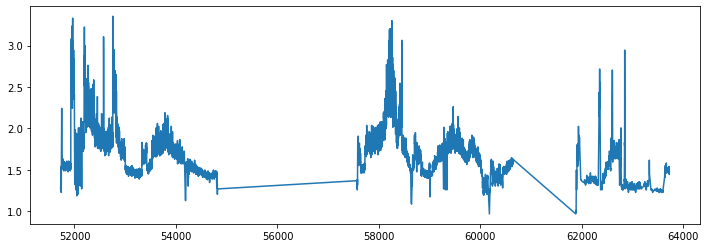

In [22]:
df['PX36BVAL'].plot(figsize=(12,4))

<AxesSubplot:>

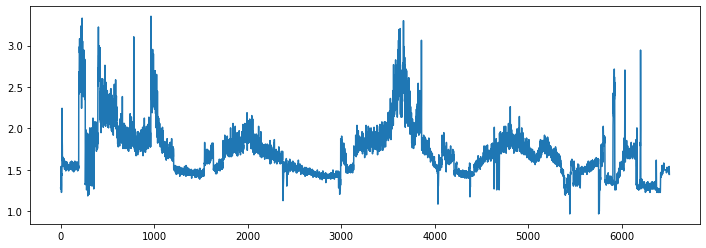

In [23]:
data['PX36BVAL'].plot(figsize=(12,4))

/tmp/ipykernel_60432/2233041483.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_output.hist(ax=ax)


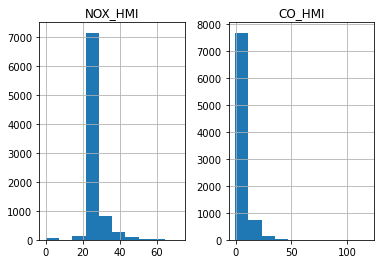

In [24]:
# to predict 'NOX_HMI','CO_HMI' compare with 'NOX15', 'CO15'
output_columns=['NOX_HMI','CO_HMI']
data_output=data[output_columns]
fig=plt.figure(figsize=(6,4))
ax=fig.gca()
data_output.hist(ax=ax)
plt.show()

In [25]:
data[output_columns].describe()

,NOX_HMI,CO_HMI
count,8597.000000,8597.000000
mean,27.279855,6.520217
std,4.818764,6.673798
min,-0.017168,-0.564966
25%,25.802547,4.131680
50%,26.937824,4.745662
75%,27.734268,5.608731
max,71.577293,118.594910


In [ ]:
#df.drop(['NOX15','CO15'],axis=1,inplace=True)

In [26]:
# check any duplicates are there
data_duplicates = data[data.duplicated()]
data_duplicates.shape

(0, 48)

In [27]:
data1=data.copy()

In [28]:
data1['PX36AVAL']=data1['PX36AVAL'].interpolate(method='linear')
data1['PX36BVAL']=data1['PX36BVAL'].interpolate(method='linear')

In [37]:
data1[cols_with_NaNs].describe() #better

,PX36AVAL,PX36BVAL
count,8597.000000,8597.000000
mean,1.473855,1.644786
std,0.266880,0.288673
min,0.816346,0.968934
25%,1.316072,1.445771
50%,1.369477,1.541139
75%,1.594545,1.777650
max,3.074648,3.353121


In [ ]:
#create a baseline model

In [119]:
#data1.info()

In [41]:
print(list(data1.columns))

['index', 'Timestamp', 'BRNDMD', 'WFPILM', 'F_FARFLI', 'F_FARFLO', 'F_FARFL', 'F_W2', 'F_WA36', 'F_WB3Q', 'F_WF36DMD', 'P2SEL', 'PS3SEL', 'T2SEL', 'T3SEL', 'TFLCYCS', 'TFLPDFS', 'TFLIDFS', 'TFLODFS', 'WFINRM', 'WFOTRM', 'WFQPERRCOR', 'A90RH', 'F_WAFL', 'NGGSEL', 'PX36SEL', 'PX36AVAL', 'PX36BVAL', 'NPTSEL', 'NPTREF', 'DWB36PCT', 'REGULATOR', 'T48SEL', 'CDPSEL', 'T8SEL', 'P48SEL', 'LHVSEL', 'SGSEL', 'NOX_HMI', 'CO_HMI', 'O2_HMI', 'VLVFBKG_06', 'EMISSIONS_SS', 'SSFILTER', 'F_WB3', 'NOX15', 'CO15', 'DateTime']


In [30]:
data1=data1.set_index('DateTime')
#right now no need
data1.drop(['NOX15', 'CO15','index','Timestamp'],axis=1,inplace=True)



In [33]:
# will split the data to 70:30 for training and testing
0.70*len(data1)

6017.9

In [124]:
train_df,test_df=data1[:6017],data1[6017:]
print(train_df.shape,test_df.shape)
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(6017, 43) (2580, 43)
(6017, 41) (6017, 2) (2580, 41) (2580, 2)


### XGB Regressor

In [116]:
other_params={'learning_rate':0.01,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
multioutputregressor=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X,train_y)

predictions=multioutputregressor.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_xgb',math.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions))
print('Root_mean_squared_error_test set_CO_HMI_xgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions[:,1])))
print('R2 Score_test set_CO_HMI_xgb',r2_score(test_y['CO_HMI'],predictions[:,1]))

print('Root_mean_squared_error_test set_NOX_xgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions[:,0])))
print('R2 Score_test set_NOX_xgb',r2_score(test_y['NOX_HMI'],predictions[:,0]))


Root_mean_squared_error_test set_xgb 5.0521731031177355
R2 Score_test set_xgb 0.3964888473389559
Root_mean_squared_error_test set_CO_HMI_xgb 4.63953114901659
R2 Score_test set_CO_HMI_xgb 0.45766541771676705
Root_mean_squared_error_test set_NOX_xgb 5.433567598276236
R2 Score_test set_NOX_xgb 0.33531227696114474


## Random Forest Regressor 

In [125]:
max_depth = 30
regr_multirf = RandomForestRegressor(n_estimators=500,
                                                         max_depth=max_depth,
                                                          random_state=0)
regr_multirf.fit(train_X, train_y)
predictions_rf=regr_multirf.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 4.2244156818291225
R2 Score_test set_rf 0.5786254169341516
Root_mean_squared_error_test set_CO_HMI_rf 3.823558059838645
R2 Score_test set_CO_HMI_rf 0.6316552475564701
Root_mean_squared_error_test set_NOX_rf 4.590400796097276
R2 Score_test set_NOX_rf 0.5255955863118347


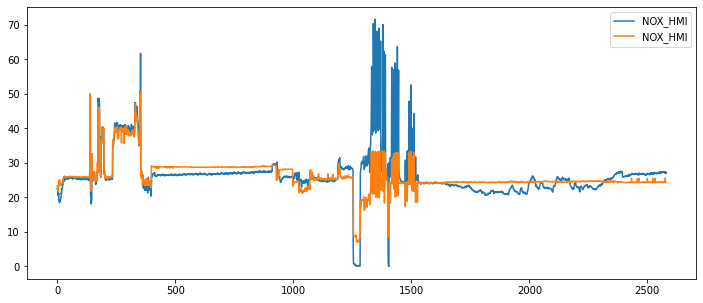

In [130]:
plt.figure(figsize=(12,5))
plt.plot(test_y['NOX_HMI'].values, label='NOX_HMI')
plt.plot(predictions_rf[:,0], label='NOX_HMI_predicted')
plt.legend()
plt.show()

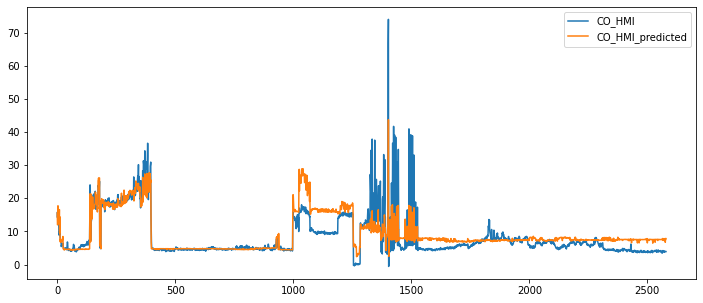

In [131]:
plt.figure(figsize=(12,5))
plt.plot(test_y['CO_HMI'].values, label='CO_HMI')
plt.plot(predictions_rf[:,1], label='CO_HMI_predicted')
plt.legend()
plt.show()

## Scale the variables and apply the algorithms

### MinMax Scaler

In [103]:

train_df,test_df=data1[:6017],data1[6017:]
print(train_df.shape,test_df.shape)
from sklearn.preprocessing import MinMaxScaler,StandardScaler
train_vars=[var for var in train_df.columns if var not in ['NOX_HMI', 'CO_HMI']]
scaler=MinMaxScaler()
scaler.fit(train_df[train_vars])
# transform the train and the test set
train_df[train_vars]=scaler.transform(train_df[train_vars])
test_df[train_vars]=scaler.transform(test_df[train_vars])
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(6017, 43) (2580, 43)
(6017, 41) (6017, 2) (2580, 41) (2580, 2)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [104]:
train_X[0:2]

,BRNDMD,WFPILM,F_FARFLI,F_FARFLO,F_FARFL,F_W2,F_WA36,F_WB3Q,F_WF36DMD,P2SEL,...,CDPSEL,T8SEL,P48SEL,LHVSEL,SGSEL,O2_HMI,VLVFBKG_06,EMISSIONS_SS,SSFILTER,F_WB3
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-10-15 11:34:00,0.0,0.084049,0.993722,0.928906,0.898286,0.078785,0.086894,0.616805,0.038220,0.436461,...,0.579334,0.088172,0.056421,0.619239,0.718622,0.999002,0.0,0.0,0.0,0.452987
2020-10-15 11:35:00,0.0,0.088107,1.000000,0.919544,0.903960,0.079742,0.088604,0.639168,0.039371,0.438305,...,0.590498,0.108387,0.055676,0.620500,0.736268,0.999055,0.0,0.0,0.0,0.469914


### XGB with MinMax Scaler

In [107]:
other_params={'learning_rate':0.01,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
multioutputregressor=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X,train_y)

predictions=multioutputregressor.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_xgb',math.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions))
print('Root_mean_squared_error_test set_CO_HMI_xgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions[:,1])))
print('R2 Score_test set_CO_HMI_xgb',r2_score(test_y['CO_HMI'],predictions[:,1]))

print('Root_mean_squared_error_test set_NOX_xgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions[:,0])))
print('R2 Score_test set_NOX_xgb',r2_score(test_y['NOX_HMI'],predictions[:,0]))


Root_mean_squared_error_test set_xgb 5.051223591754206
R2 Score_test set_xgb 0.3967048277436747
Root_mean_squared_error_test set_CO_HMI_xgb 4.639531178185099
R2 Score_test set_CO_HMI_xgb 0.45766541089750423
Root_mean_squared_error_test set_NOX_xgb 5.431801726355345
R2 Score_test set_NOX_xgb 0.3357442445898452


### RF with MinMax Scaler

In [108]:

max_depth = 30
regr_multirf = RandomForestRegressor(n_estimators=500,
                                                          max_depth=max_depth,
                                                          random_state=0)
regr_multirf.fit(train_X, train_y)


predictions_rf=regr_multirf.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 4.243677120600681
R2 Score_test set_rf 0.5744416738822588
Root_mean_squared_error_test set_CO_HMI_rf 3.8731322562568193
R2 Score_test set_CO_HMI_rf 0.622041807902461
Root_mean_squared_error_test set_NOX_rf 4.58436882606126
R2 Score_test set_NOX_rf 0.5268415398620572


### Standard Scaler

In [109]:

train_df,test_df=data1[:6017],data1[6017:]
print(train_df.shape,test_df.shape)
from sklearn.preprocessing import MinMaxScaler,StandardScaler
train_vars=[var for var in train_df.columns if var not in ['NOX_HMI', 'CO_HMI']]
scaler=StandardScaler()
scaler.fit(train_df[train_vars])
# transform the train and the test set
train_df[train_vars]=scaler.transform(train_df[train_vars])
test_df[train_vars]=scaler.transform(test_df[train_vars])
OUTPUT_COLUMNS=['NOX_HMI','CO_HMI']
train_X=train_df.drop(OUTPUT_COLUMNS,axis=1)
train_y=train_df[OUTPUT_COLUMNS]
test_X=test_df.drop(OUTPUT_COLUMNS,axis=1)
test_y=test_df[OUTPUT_COLUMNS]
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(6017, 43) (2580, 43)
(6017, 41) (6017, 2) (2580, 41) (2580, 2)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [110]:
train_X[0:2]

,BRNDMD,WFPILM,F_FARFLI,F_FARFLO,F_FARFL,F_W2,F_WA36,F_WB3Q,F_WF36DMD,P2SEL,...,CDPSEL,T8SEL,P48SEL,LHVSEL,SGSEL,O2_HMI,VLVFBKG_06,EMISSIONS_SS,SSFILTER,F_WB3
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-10-15 11:34:00,-8.586083,-10.701227,9.190551,8.474068,7.866322,-11.138679,-9.977922,5.329113,-10.001721,0.244025,...,4.832486,-11.192810,-9.696328,-0.102723,1.519041,13.004105,-13.895927,0.0,-3.054505,3.187264
2020-10-15 11:35:00,-8.586083,-10.643050,9.263796,8.378820,7.923088,-11.126386,-9.957937,5.530934,-9.989063,0.253497,...,4.931034,-10.911018,-9.704412,-0.097260,1.607770,13.006324,-13.895927,0.0,-3.054505,3.316580


### XGB_Standard Scaler

In [111]:
other_params={'learning_rate':0.01,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
multioutputregressor=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X,train_y)

predictions=multioutputregressor.predict(test_X)

#for test set
print('Root_mean_squared_error_test set_xgb',math.sqrt(mean_squared_error(test_y,predictions)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions))
print('Root_mean_squared_error_test set_CO_HMI_xgb',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions[:,1])))
print('R2 Score_test set_CO_HMI_xgb',r2_score(test_y['CO_HMI'],predictions[:,1]))

print('Root_mean_squared_error_test set_NOX_xgb',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions[:,0])))
print('R2 Score_test set_NOX_xgb',r2_score(test_y['NOX_HMI'],predictions[:,0]))


Root_mean_squared_error_test set_xgb 5.0521731031177355
R2 Score_test set_xgb 0.3964888473389559
Root_mean_squared_error_test set_CO_HMI_xgb 4.63953114901659
R2 Score_test set_CO_HMI_xgb 0.45766541771676705
Root_mean_squared_error_test set_NOX_xgb 5.433567598276236
R2 Score_test set_NOX_xgb 0.33531227696114474


### RF with Standard Scaler

In [112]:
max_depth = 30
regr_multirf = RandomForestRegressor(n_estimators=500,
                                                        max_depth=max_depth,
                                                          random_state=0)
regr_multirf.fit(train_X, train_y)
predictions_rf=regr_multirf.predict(test_X)
#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 4.2244156818291225
R2 Score_test set_rf 0.5786254169341516
Root_mean_squared_error_test set_CO_HMI_rf 3.823558059838645
R2 Score_test set_CO_HMI_rf 0.6316552475564701
Root_mean_squared_error_test set_NOX_rf 4.590400796097276
R2 Score_test set_NOX_rf 0.5255955863118347


In [122]:
# 100-1000 estimators do not make much difference, 500 is fine
max_depth = 10
regr_multirf = RandomForestRegressor(n_estimators=100,
                                                        max_depth=max_depth,
                                                          random_state=0)
regr_multirf.fit(train_X, train_y)
predictions_rf=regr_multirf.predict(test_X)
#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 4.179436837835722
R2 Score_test set_rf 0.5818378252872861
Root_mean_squared_error_test set_CO_HMI_rf 4.309387061993893
R2 Score_test set_CO_HMI_rf 0.5321031563084562
Root_mean_squared_error_test set_NOX_rf 4.045314290983598
R2 Score_test set_NOX_rf 0.6315724942661165


In [123]:
# 100-1000 estimators do not make much difference, 500 is fine
max_depth = 10
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                        max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(train_X, train_y)
predictions_rf=regr_multirf.predict(test_X)
#for test set
print('Root_mean_squared_error_test set_rf',math.sqrt(mean_squared_error(test_y,predictions_rf)))
print('R2 Score_test set_rf',r2_score(test_y,predictions_rf))
print('Root_mean_squared_error_test set_CO_HMI_rf',math.sqrt(mean_squared_error(test_y['CO_HMI'],predictions_rf[:,1])))
print('R2 Score_test set_CO_HMI_rf',r2_score(test_y['CO_HMI'],predictions_rf[:,1]))
print('Root_mean_squared_error_test set_NOX_rf',math.sqrt(mean_squared_error(test_y['NOX_HMI'],predictions_rf[:,0])))
print('R2 Score_test set_NOX_rf',r2_score(test_y['NOX_HMI'],predictions_rf[:,0]))

Root_mean_squared_error_test set_rf 5.774539517171576
R2 Score_test set_rf 0.1824524388053207
Root_mean_squared_error_test set_CO_HMI_rf 7.0595441536578365
R2 Score_test set_CO_HMI_rf -0.2556610601518219
Root_mean_squared_error_test set_NOX_rf 4.105295313775579
R2 Score_test set_NOX_rf 0.6205659377624633


In [ ]:
## some more data analysis 

#data1.hist(figsize=(15,20))

#data1.describe()

In [ ]:
# plt.figure(figsize=(12,5))
# plt.plot(CO_NO_predictions['CO_HMI_real'], label='CO_Real')
# plt.plot(CO_NO_predictions['CO_HMI_predicted'], label='CO_Predicted')
# plt.legend()
# plt.show()

# plt.figure(figsize=(12,5))
# plt.plot(CO_NO_predictions['NOX_HMI_real'], label='NOX_Real')
# plt.plot(CO_NO_predictions['NOX_HMI_predicted'], label='NOX_Predicted')
# plt.legend()
# plt.show()